# Convolutions in action

In [1]:
import torch

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import datetime

data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


Here we have 3 input features per pixel (the RGB channels) and an arbitrary number of channels in the output (16). We need the channels to be able to detect many different types of features. Also, because we are randomly initializing them, some of the features we’ll get, even after training, will turn out to be useless.2 Let’s stick to a kernel size of 3 × 3. A 2D convolution pass produces a 2D image as output, whose pixels are a weighted sum over neighborhoods of the input image.

In our case, both the kernel weights and the bias conv.weight are initialized randomly, so the output image will not be particu- larly meaningful. As usual, we need to add the zeroth batch dimension with unsqueeze if we want to call the conv module with one input image, since nn.Conv2d expects a Batches × Channels × Height × Width shaped tensor as input.

In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3)
print('Shape of kernel weights and bias')
print(conv.weight.shape, conv.bias.shape)
print('')
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
print('Shape of input and output')
print(img.unsqueeze(0).shape, output.shape)

Shape of kernel weights and bias
torch.Size([16, 3, 3, 3]) torch.Size([16])

Shape of input and output
torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


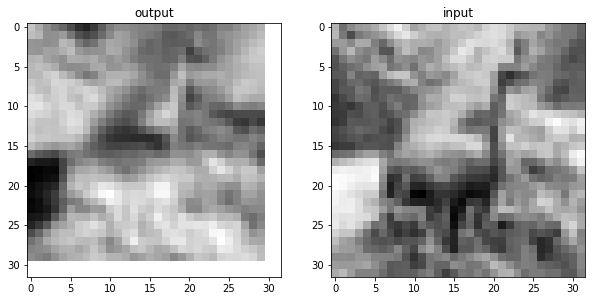

In [4]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

#### Kernel 1
Each pixel in the output gets the mean of its neighbor (3x3)

torch.Size([1, 3, 32, 32]) torch.Size([1, 1, 32, 32])
Output after appplying the Kernel that averages based on neighborhood pixels


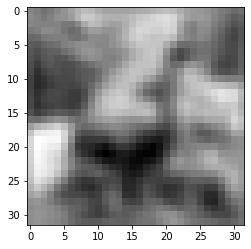

In [5]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
print(img.unsqueeze(0).shape, output.shape)
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)
    
print('Output after appplying the Kernel that averages based on neighborhood pixels')
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

#### Kernel 2
convolution kernel enhances the vertical edges. When an edge is "detected" that means that the output has a high magnitude.

In [6]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

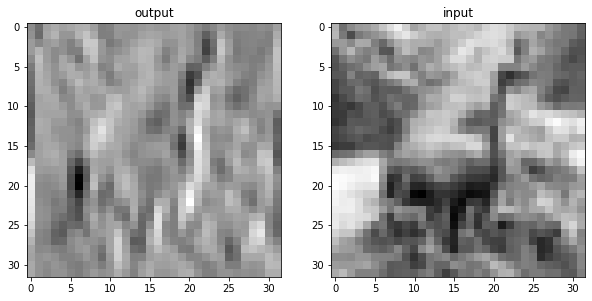

In [7]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

#### Downsampling technique example
Downsample our image by half by using the max pooling technique, we’ll want to use a size of 2.

In [8]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

#### NN structure
1. The 1st convolution takes us from 3 RGB channels to 16. These 16 independent features are being used to discriminate low-level features of birds and airplanes
2. The tanh activation function and yield a resulting 16-channel 32x32 image
3. Applying MaxPool2d(2) module shrinks the output to a 16-channel 16x16 image.
4. The image is convolved and yields an 8 channel 16 x 16 output which will consist of higher level features
5. The tanh activation function and yield a resulting 8-channel 16x16 image
6. Applying MaxPool2d(2) module shrinks the output to a 8-channel 8x8 image

In [9]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), #1
            nn.Tanh(), #2
            nn.MaxPool2d(2), #3
            nn.Conv2d(16, 8, kernel_size=3, padding=1), #4
            nn.Tanh(), #5
            nn.MaxPool2d(2),#6
            # ... <1> ERROR
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [10]:
numel_list = [p.numel() for p in model.parameters()]
print('Total number of parameters:' + '\n' + str(sum(numel_list)))
print('Number of parameters per layer:' + '\n' + str(numel_list))

Total number of parameters:
18090
Number of parameters per layer:
[432, 16, 1152, 8, 16384, 32, 64, 2]


### Writing our network as a nn.Module

A forward function is defined here, that takes the inputs to the module and returns the output. This is where we define our module’s computation. Writing the forward function explicitly allows us to manipulate the outputs between layers. 

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) 
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        
        #This reshape is what we were missing earlier
        out = out.view(-1, 8 * 8 * 8)
        
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [12]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

#### Benefits of using functional counterpart for every nn module
Functional essentially means having no internal state. Submodules such as nn.Tanh and nn.MaxPool2d do not have parameters and their output value is solely and fully determined by the value input arguments. 

torch.nn.functional takes inputs and parameters as arguments to the function call, instead of working on the input arguments and stored parameters (like its module counterparts)

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [14]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0641,  0.0351]], grad_fn=<AddmmBackward0>)

## Training
<strong>Function breakdown:</strong>
1. Looping over the epochs numbered from 1 to n_epochs. The training loop function takes the number of epocs as an input.
2. Loops over the dataset in the batches which were created by the data loader 
3. Fits a batch of our model
4. Computes the loss which we try to minimize
5. Getting rid of the gradients from the last iteration in the loop
6. Performs the backward step. That is, we compute the gradients of all parameters we want the network to learn.
7. Updates the model
8. Sums the losses we saw over the epoch. The loss is transformed to a Python number with .item(), to escape the gradients.
9. Divides by the length of the training data loader to get the average loss per batch. This is a much more intuitive measure than the sum.

In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <1>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <2>
            
            outputs = model(imgs)  # <3>
            
            loss = loss_fn(outputs, labels)  # <4>

            optimizer.zero_grad()  # <5>
            
            loss.backward()  # <6>
            
            optimizer.step()  # <7>

            loss_train += loss.item()  # <8>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <9>

<strong>Arguments breakdown:</strong>
1. <strong>n_epochs</strong> <br>
Number of epochs which we wish to train the model. Looping over the epochs numbered from 1 to n_epochs. 
2. <strong>optimizer</strong> <br>
- An optimizer is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. Thus, it helps in reducing the overall loss and improve the accuracy. In SGD we find out the gradient of the cost function of a single example at each iteration instead of the sum of the gradient of the cost function of all the examples.<br>
- Since only one sample from the dataset is chosen at random for each iteration, the path taken by the algorithm to reach the minima is usually noisier than your typical Gradient Descent algorithm <br>
- If you look at the pseudocode using the link below, it's clear that theta will be updated until gradient is equal to 0. When the gradient equal to 0, that means that the theta(cost) is at a point where it reached the local (or global ideally, but probably not) minima of the function.<br>
(https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/)
3. <strong>model</strong> <br>
Instatiate the model and assign it to the training function.
4. <strong>loss_fn</strong> <br>
Loss functions are used to gauge the error between the prediction output and the provided target value.The word 'loss' means the penalty that the model gets for failing to yield the desired results.<br>
(https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e)
5. <strong>train_loader</strong> <br>
Combines a dataset and a sampler, and provides an iterable (just like a list) over the given dataset.
(https://pytorch.org/docs/stable/data.html#:~:text=Data%20loader.,(collation)%20and%20memory%20pinning.)

In [20]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss()  

training_loop(  # <5>
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-08-31 02:17:18.091802 Epoch 1, Training loss 0.5574129527541483


KeyboardInterrupt: 